# Để xây dựng mô hình dự báo biến động giá cổ phiếu, em sẽ sử dụng phương pháp LSTM (mạng neuron dài và ngắn)

In [1]:
import pandas as pd # Đọc và xử lý dữ liệu
import numpy as np # Xử lý dữ liệu
from datetime import datetime as datetime # Chỉnh dữ liệu thời gian
import matplotlib.pyplot as plt # Vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler # Chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint # Lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model # Tải mô hình

# Các lớp để xây dựng mô hình
from keras.models import Sequential # Đầu vào
from keras.layers import LSTM # Học phụ thuộc
from keras.layers import Dropout # Tránh học tủ
from keras.layers import Dense # Đầu ra




# Kiểm định độ chính xác của mô hình
from sklearn.metrics import r2_score # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error # Đo phần trăm sai số tuyệt đối trung bình


# Đọc, xử lý và biến đổi dữ liệu

In [2]:
df = pd.read_csv('PNJ.csv')
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,PNJ,2/28/2018 9:15,78.14,78.99,78.14,78.99,270,0
1,PNJ,2/28/2018 9:16,78.94,78.94,78.94,78.94,10,0
2,PNJ,2/28/2018 9:19,78.14,78.14,78.14,78.14,283,0
3,PNJ,2/28/2018 9:20,78.14,78.14,78.14,78.14,480,0
4,PNJ,2/28/2018 9:21,78.14,78.14,78.14,78.14,146,0


In [3]:
# Thông tin bộ dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125309 entries, 0 to 125308
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         125309 non-null  object 
 1   Date/Time      125309 non-null  object 
 2   Open           125309 non-null  float64
 3   High           125309 non-null  float64
 4   Low            125309 non-null  float64
 5   Close          125309 non-null  float64
 6   Volume         125309 non-null  int64  
 7   Open Interest  125309 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 7.6+ MB


=> Không có dữ liệu khuyết thiếu

In [4]:
# Mô tả bộ dữ liệu
df.describe()

,Open,High,Low,Close,Volume,Open Interest
count,125309.000000,125309.000000,125309.000000,125309.000000,125309.000000,125309.0
mean,72.182052,72.372590,72.042287,72.179371,3031.830451,0.0
std,9.900263,9.995786,9.830847,9.899401,7248.952968,0.0
min,44.430000,44.530000,44.040000,44.140000,1.000000,0.0
25%,64.600000,64.700000,64.570000,64.600000,220.000000,0.0
50%,72.800000,73.010000,72.640000,72.830000,1000.000000,0.0
75%,80.160000,80.350000,80.060000,80.160000,3130.000000,0.0
max,100.160000,100.160000,100.160000,100.160000,580730.000000,0.0


In [5]:
df['Date/Time'] = pd.to_datetime(df["Date/Time"]) # chỉnh kiểu dữ liệu của cột Date/Time
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,PNJ,2018-02-28 09:15:00,78.14,78.99,78.14,78.99,270,0
1,PNJ,2018-02-28 09:16:00,78.94,78.94,78.94,78.94,10,0
2,PNJ,2018-02-28 09:19:00,78.14,78.14,78.14,78.14,283,0
3,PNJ,2018-02-28 09:20:00,78.14,78.14,78.14,78.14,480,0
4,PNJ,2018-02-28 09:21:00,78.14,78.14,78.14,78.14,146,0


In [6]:
# Tạo list ngày tháng năm
Date = []
for i in df['Date/Time']:
    if datetime.strftime(i,"%Y-%m-%d") not in Date:
        Date.append(datetime.strftime(i,"%Y-%m-%d"))
print(Date)

['2018-02-28', '2018-03-01', '2018-03-02', '2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08', '2018-03-09', '2018-03-12', '2018-03-13', '2018-03-14', '2018-03-15', '2018-03-16', '2018-03-19', '2018-03-20', '2018-03-21', '2018-03-22', '2018-03-23', '2018-03-26', '2018-03-27', '2018-03-28', '2018-03-29', '2018-03-30', '2018-04-02', '2018-04-03', '2018-04-04', '2018-04-05', '2018-04-06', '2018-04-09', '2018-04-10', '2018-04-11', '2018-04-12', '2018-04-13', '2018-04-16', '2018-04-17', '2018-04-18', '2018-04-19', '2018-04-20', '2018-04-23', '2018-04-24', '2018-04-26', '2018-04-27', '2018-05-02', '2018-05-03', '2018-05-04', '2018-05-07', '2018-05-08', '2018-05-09', '2018-05-10', '2018-05-11', '2018-05-14', '2018-05-15', '2018-05-16', '2018-05-17', '2018-05-18', '2018-05-21', '2018-05-22', '2018-05-23', '2018-05-24', '2018-05-25', '2018-05-28', '2018-05-29', '2018-05-30', '2018-05-31', '2018-06-01', '2018-06-04', '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-11', '2018

In [7]:
# Tạo list giá mở cửa, đóng cửa, cao nhất, thấp nhất
Open = []
High = []
Low = []
Close = []
for date in Date:
    subset = df[df['Date/Time'].dt.date == datetime.strptime(date, '%Y-%m-%d').date()]
    Open.append(subset.iloc[0]['Open'])
    High.append(subset['High'].max())
    Low.append(subset['Low'].min())
    Close.append(subset.iloc[-1]['Close'])

In [8]:
# Tạo 1 dataframe chứa dữ liệu giao dịch theo từng ngày
price_data_series = {
    'Tiker':df['Ticker'][:len(Date)],
    'Date': Date,
    'Open': Open,
    'High':High,
    'Low':Low,
    'Close':Close
}
PNJ = pd.DataFrame(price_data_series)
PNJ

,Tiker,Date,Open,High,Low,Close
0,PNJ,2018-02-28,78.14,80.61,78.09,78.71
1,PNJ,2018-03-01,78.14,80.32,77.66,77.66
2,PNJ,2018-03-02,77.14,77.90,76.86,77.33
3,PNJ,2018-03-05,77.14,80.50,77.14,78.28
4,PNJ,2018-03-06,78.61,83.13,77.43,81.45
...,...,...,...,...,...,...
704,PNJ,2020-12-16,77.20,77.60,77.00,77.60
705,PNJ,2020-12-17,76.50,77.40,75.00,75.80
706,PNJ,2020-12-18,75.80,77.50,75.80,77.30
707,PNJ,2020-12-21,77.30,77.40,76.50,77.30


Mô hình của sẽ sử dụng dữ liệu của giá đóng cửa trong quá khứ làm cơ sở để dự báo giá trong tương lai

=> Vì vậy sẽ lấy ra dữ liệu ngày và giá đóng cửa trong Dataframe PNJ

In [10]:
df1 = pd.DataFrame(PNJ, columns=['Date','Close'])
df1['Date'] = pd.to_datetime(df1['Date'])
df1.index = df1['Date']
df1.drop('Date',axis=1,inplace=True)
df1

,Close
Date,
2018-02-28,78.71
2018-03-01,77.66
2018-03-02,77.33
2018-03-05,78.28
2018-03-06,81.45
...,...
2020-12-16,77.60
2020-12-17,75.80
2020-12-18,77.30


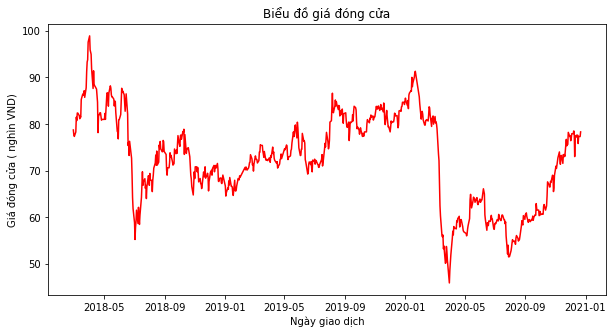

In [11]:
# Vẽ biểu đồ giá đóng cửa 
plt.figure(figsize=(10,5))
plt.plot(df1['Close'],label='Giá thực tế',color='red')
plt.title('Biểu đồ giá đóng cửa')
plt.xlabel('Ngày giao dịch')
plt.ylabel('Giá đóng cửa ( nghìn VND)')
plt.show()

Nhìn vào biểu đồ biến động giá đóng cửa của PNJ, thấy được:
+ Vì đặc thù của PNJ là sản xuất, xuất nhập khẩu và kinh doanh trang sức, nên thời điểm sau hết Tết Nguyên Đán (thường là cuối tháng 1, giữa tháng 2) giai đoạn này hầu như năm nào PNJ cũng tăng trưởng rất mạnh do nhu cầu mua trang sức của người tiêu dùng ( đặc biệt là sản phẩm vàng ) và sau tầm hơn 1 tháng sau đó sẽ điều chỉnh về mức giá thấp hơn
+ Cũng giống như toàn thị trường, PNJ cũng bị ảnh hưởng bởi Covid 19, thậm chí là mạnh (cú sập khiến PNJ giảm mất 1 nửa giá từ xung quanh 90 nghìn VND còn 45.9 nghìn VND )
+ Tới cuối năm 2020 PNJ đã hồi phục về vùng giá gần 80 nghìn VND/1cp

In [13]:
# Chia tập dữ liệu ra thành 2 phần train và test để đánh giá hiệu suất của mô hình học máy trên tập dữ liệu

data = df1.values
train_data = data[:600]
test_data = data[600:]

In [14]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0,1))
# MinmaxScaler sẽ điều chỉnh dữ liệu: giá trị nhỏ nhất sẽ là 0, giá trị lớn nhất sẽ là 1, các giá trị khác sẽ theo tỷ lệ giữa 0 và 1
sc_train = sc.fit_transform(data)

In [15]:
# Ý tưởng của mô hình là sử dụng giá của 30 ngày liên tục để dự đoán giá của ngày tiếp theo
x_train, y_train = [],[]
for i in range(30,len(train_data)):
    x_train.append(sc_train[i-30:i,0])
    y_train.append(sc_train[i,0])

=> x_train sẽ bao gồm các mảng, mỗi bảng sẽ bao gồm 30 giá đóng cửa liên tục
    y_train sẽ bao gồm 1 danh sách giá đóng cửa của ngày hôm sau tương ứng với mỗi mảng của x_train

In [16]:
# Sắp xếp dữ liệu thành 1 mảng
x_train = np.array(x_train)
y_train = np.array(y_train)

# xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

# Xây dựng và huấn luyện mô hình

In [17]:
import os
# Bao gồm 5 lớp mô hình
from tensorflow.keras.callbacks import ModelCheckpoint
model = Sequential() # Lớp đầu vào input, tạo lớp mạng cho dữ liệu đầu vào
model.add(LSTM(units=128, input_shape=(x_train.shape[1],1), return_sequences=True)) # Mô tả thông tin của đầu vào 
model.add(LSTM(units=64))
model.add(Dropout(0.5)) # Lớp dropout sẽ random đặt 1 số giá trị trong lúc training về bằng 0 để buộc cho máy học phải học lại, tránh tình trạng overfit ( học tủ )
model.add(Dense(units=1)) # Lớp output với đầu ra 1 chiều
model.compile(loss="mean_absolute_error", optimizer='adam') # hàm sai số loss sẽ đo sai số tuyệt đối trung bình
save_model = "C:/Users/DD/Desktop/Phân tích và dự báo giá chứng khoán/model6.hdf5" # sau khi training sẽ lưu vào file dạng HDF5

best_model = ModelCheckpoint( monitor='loss', verbose=1, save_best_only=True, mode="min",filepath=save_model) # Training tìm ra mô hình huấn luyện tốt nhất và chỉ lưu duy nhất 1 kết quả
model.fit(x_train, y_train, epochs=100, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.20315, saving model to C:/Users/DD/Desktop/Phân tích và dự báo giá chứng khoán\model6.hdf5
12/12 - 4s - loss: 0.2032 - 4s/epoch - 293ms/step
Epoch 2/100

Epoch 2: loss improved from 0.20315 to 0.10248, saving model to C:/Users/DD/Desktop/Phân tích và dự báo giá chứng khoán\model6.hdf5
12/12 - 0s - loss: 0.1025 - 353ms/epoch - 29ms/step
Epoch 3/100

Epoch 3: loss improved from 0.10248 to 0.08983, saving model to C:/Users/DD/Desktop/Phân tích và dự báo giá chứng khoán\model6.hdf5
12/12 - 0s - loss: 0.0898 - 340ms/epoch - 28ms/step
Epoch 4/100

Epoch 4: loss improved from 0.08983 to 0.08507, saving model to C:/Users/DD/Desktop/Phân tích và dự báo giá chứng khoán\model6.hdf5
12/12 - 0s - loss: 0.0851 - 331ms/epoch - 28ms/step
Epoch 5/100

Epoch 5: loss did not improve from 0.08507
12/12 - 0s - loss: 0.0855 - 312ms/epoch - 26ms/step
Epoch 6/100

Epoch 6: loss improved from 0.08507 to 0.08115, saving model to C:/Users/DD/Desktop/Phân tích và 

Trong 100 lần training nếu mô hình nào có sai số tuyệt đối trung bình nhỏ hơn mô hình trước thì sẽ được tự động lưu vào file HDF5 và ghi đè lên mô hình đã lưu trước đó ( Vì save_best_only = True)

In [18]:
# Sau khi tìm được mô hình tốt nhất và lưu trong file 'model6.hdf5', tải lên lại mô hình và áp dụng dự đoán vào tập train
import io
import h5py
with open('model6.hdf5', 'rb') as f:
    file_content = f.read()
    with io.BytesIO(file_content) as file:
        with h5py.File(file, 'r') as hdf:
            final_model = load_model(hdf)

y_train = sc.inverse_transform(y_train) # giá thực
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict) # Giá dự đoán

# Dùng inverse_tranform để điều chỉnh về định dạnh dữ liệu gốc vì dữ liệu đang được chuẩn hóa ở dạng trong khoảng từ 0 đến 1

18/18 [==============================] - 1s 8ms/step


# Sử dụng mô hình

In [19]:
# Với tập test làm tương tự như tập train
test = df1[len(train_data)-30:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(30,test.shape[0]):
    x_test.append(sc_test[i-30:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))


# dữ liệu test
y_test = data[600:] # Giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) # giá dự đoán

4/4 [==============================] - 0s 6ms/step


# Độ chính xác của mô hình

C:\Users\DD\AppData\Local\Temp\ipykernel_1468\3255169889.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['dự đoán'] = y_train_predict
C:\Users\DD\AppData\Local\Temp\ipykernel_1468\3255169889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict


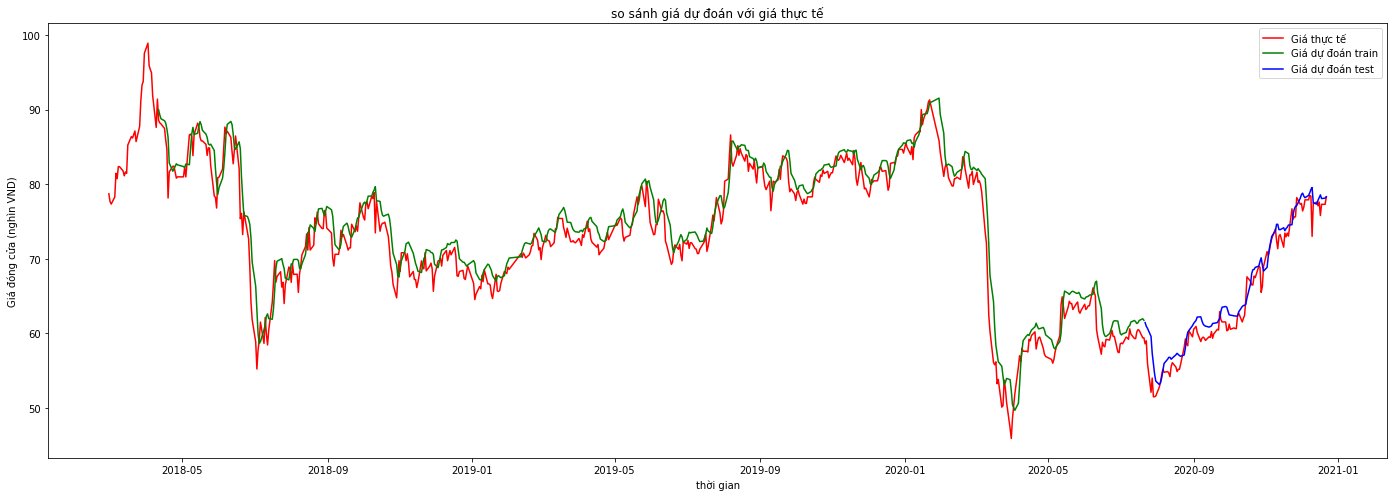

In [20]:
train_data1 = df1[30:600]
test_data1 = df1[600:]

plt.figure(figsize=(24,8))

plt.plot(df1,label='Giá thực tế',color='red')


train_data1['dự đoán'] = y_train_predict

plt.plot(train_data1['dự đoán'], label='Giá dự đoán train', color='green')


test_data1['Dự đoán'] = y_test_predict
plt.plot(test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')

plt.title("so sánh giá dự đoán với giá thực tế")

plt.xlabel('thời gian')

plt.ylabel('Giá đóng cửa (nghìn VND)')
plt.legend()

plt.show()

Để kiểm tra độ chính xác của mô hình, đầu tiên ta lập biểu đồ so sánh ở trên cả 2 tập.

+ Với giá thực tế của cổ phiếu được biểu diễn bằng đường màu đỏ
+ Giá dự đoán của tập train được biểu diễn bằng đường màu xanh lá
+ Giá dự đoán của tập test được biển diễn bằng đường màu xanh dương

Để cụ thể hơn thì sẽ đánh giá bằng r2_score

In [21]:
#r2
print('Độ phù hợp của tập train: ',r2_score(y_train, y_train_predict))

#mae
print('Sai số tuyệt đối trung bình tập train: ',mean_absolute_error(y_train,y_train_predict))

#mape
print('Phần trăm sai số tuyệt đối trung bình tập train: ',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp của tập train:  0.9224691267812236
Sai số tuyệt đối trung bình tập train:  1.8686700546532344
Phần trăm sai số tuyệt đối trung bình tập train:  0.026834893755565747


In [22]:
train_data1

,Close,dự đoán
Date,,
2018-04-11,88.56,89.969200
2018-04-12,88.22,89.289948
2018-04-13,88.08,88.770325
2018-04-16,87.47,88.505608
2018-04-17,85.95,88.199120
...,...,...
2020-07-15,60.20,61.320629
2020-07-16,60.50,61.427341
2020-07-17,60.40,61.725658


In [23]:
#r2
print('Độ phù hợp của tập test: ',r2_score(y_test, y_test_predict))

#mae
print('Sai số tuyệt đối trung bình tập test: ',mean_absolute_error(y_test,y_test_predict))

#mape
print('Phần trăm sai số tuyệt đối trung bình tập train: ',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp của tập test:  0.9433131522901582
Sai số tuyệt đối trung bình tập test:  1.5264243589628725
Phần trăm sai số tuyệt đối trung bình tập train:  0.02465328920349834


In [24]:
test_data1

,Close,Dự đoán
Date,,
2020-07-22,58.6,61.449451
2020-07-23,59.0,60.951679
2020-07-24,56.0,60.680084
2020-07-27,52.1,59.594826
2020-07-28,54.0,57.326813
...,...,...
2020-12-16,77.6,78.193573
2020-12-17,75.8,78.564148
2020-12-18,77.3,78.069275
